<a href="https://colab.research.google.com/github/felipe-gm/ifusp_fiscomp_2/blob/master/2020_04_01/Questao1_1e2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Related third party imports

In [0]:
import matplotlib.pyplot as plt

from numpy import arange, array, sin, cos, arccos, exp

Variaveis globais

In [0]:
a = .0        # Inicio do intervalo da variavel independente 
b = 100.      # Final do intervalo da variavel independente
h = 1e-2      # Tamanho inicial de um passo de integracao
prec = 1e-4   # Precisao desejada do passo

Constantes

In [0]:
K, M, RHO, F_EXT, OMEGA_EXT = 1., 1., .4, 1., .1

# Equacoes de diferenca

In [0]:
def f(r,t):
    x, y = r[0], r[1]
    fx, fy = y, (-K*x -RHO*y +F_EXT*cos(OMEGA_EXT*t))/M
    return array([fx, fy], float)

In [0]:
def solucao_analitica(t):
    return x_trans(t) + x_est(t)

In [0]:
def x_est(t):
    omega_0 = (K/M)**(1/2)
    gamma = RHO/M

    A_ext = F_EXT/(
        M
        *(
            (omega_0**2 - OMEGA_EXT**2)**2
            + gamma**2 * OMEGA_EXT**2
        )**(1/2)
    )

    phi = -arccos(
        (omega_0**2 - OMEGA_EXT**2)
        /(
            (omega_0**2 - OMEGA_EXT**2)**2
            + gamma**2 * OMEGA_EXT**2
        )**(1/2)
    )

    return A_ext * cos(OMEGA_EXT*t + phi)

In [0]:
def x_trans(t):
    omega_0 = (K/M)**(1/2)
    gamma = RHO/M

    omega = (omega_0**2 - (gamma**2)/4)**(1/2)

    alpha, beta = (1.-x_est(a)), (-1. + gamma*(1.-x_est(a))/2.)/omega

    return exp(-gamma*t/2)*(alpha*cos(omega*t) + beta*sin(omega*t))

# Integracao numerica

In [0]:
def passo_rk4(f,r,t,h):
    """Calcula um passo no metodo de RK4

    Positional arguments:
    f -- equacao de difereca multidimensional (type function)
    r -- vetor vetor de posicao no espaco de estados (type numpy.ndarray)
    t -- tempo (type float)
    h -- tamnho de um passo de integracao (type float)
    """
    k1 = h*f(r,t)
    k2 = h*f(r+.5*k1,t+.5*h)
    k3 = h*f(r+.5*k2,t+.5*h)
    k4 = h*f(r+k3,t+h)
    return (k1+2.*(k2+k3)+k4)/6.

In [0]:
def passo_adapt_extloc(f,r,t,h,prec): # Passo adaptativo com extrapolação local
    razao = 1.0 + 1e-10               # Começamos com uma razão igual a 1
    while razao >= 1.0 + 1e-10:       # Laço até que a razão seja menor que 1
        h /= razao                              # Ajustamos o tamanho do passo
        dr21 = passo_rk4(f,r,t,h)               # Um passo de tamanho h
        dr2 = dr21 + passo_rk4(f,r+dr21,t+h,h)  # Dois passos de tamanho h
        dr1 = passo_rk4(f,r,t,2*h)              # Um só passo de tamanho 2h
        epsilon = (dr2 - dr1)/30
        # Erro estimado em um passo h:
        erro = abs(epsilon[0]) 
        razao = (erro/(h*prec))**0.25
    h_prox = min(h/(razao+1e-10),2*h)           # Limitando o aumento do passo
    dr = dr2 + (dr2 - dr1)/15
    return dr, 2*h, h_prox      # Retorna o incremento de r e os tamanhos
                                # do passo atual e do próximo passo 

Condicoes iniciais (e.g.: r(a))

In [0]:
ra = array([1.,-1.],float)
r = ra
t = a
h_atual = h

t_lista, x_lista, v_lista, h_lista = [], [], [], []

In [0]:
while t<=b:
    t_lista.append(t)
    x_lista.append(r[0])
    v_lista.append(r[1])
    h_lista.append(h_atual)
    dr, h_atual, h_prox = passo_adapt_extloc(f,r,t,h,prec)
    t, r = t + h_atual, r + dr
    h = h_prox

In [0]:
x_exato = [] 
t_exato = arange(a,b,1e-2)
for t in t_exato:  # Criando a lista com a solução exata
    x_exato.append(solucao_analitica(t))

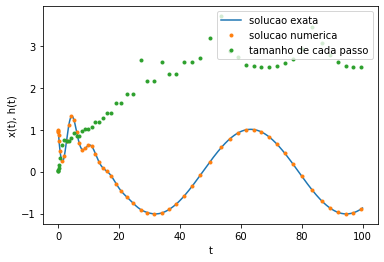

In [0]:
plt.plot(t_exato, x_exato, label='solucao exata')
plt.plot(t_lista, x_lista, '.', label='solucao numerica')
plt.plot(t_lista, h_lista, '.', label='tamanho de cada passo')
plt.xlabel("t")
plt.ylabel("x(t), h(t)")
plt.legend(loc='upper right')
plt.show()